In [341]:
from textblob import TextBlob
import numpy as np
import pandas as pd
import nltk
pd.options.display.max_columns = None
from sklearn import linear_model
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn import set_config
from sklearn.base import clone
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from feature_engine.preprocessing import MatchVariables
from feature_engine.encoding import RareLabelEncoder, OrdinalEncoder, OneHotEncoder
from feature_engine.imputation import (
    AddMissingIndicator, MeanMedianImputer, CategoricalImputer, EndTailImputer
)
from feature_engine.transformation import PowerTransformer
from feature_engine.creation import RelativeFeatures
from feature_engine.selection import DropFeatures
plt.style.use('ggplot')
df = pd.read_excel('/Users/manu/Analisis Predictivo/Final/2022-03-16 dataset on student dropout .xlsx')

In [342]:
df.head()

,student.id,generation,educational.model,level,gender,age,max.degree.parents,father.education.complete,father.education.summary,mother.education.complete,mother.education.summary,parents.exatec,father.exatec,mother.exatec,tec.no.tec,foreign,zone.type,first.generation,school,program,region,PNA,admission.test,online.test,english.evaluation,admission.rubric,general.math.eval,retention,FTE,scholarship.perc,scholarship.type,loan.perc,total.scholarship.loan,school.cost,id.school.origin,socioeconomic.level,social.lag,average.first.period,failed.subject.first.period,dropped.subject.first.period,dropout.semester,physical.education,cultural.diffusion,student.society,total.life.activities,athletic.sports,art.culture,student.society.leadership,life.work.mentoring,wellness.activities
0,1,AD15,0,High School,Male,15,No information,No information,No information,No information,No information,No information,No information,No information,TEC,Local,No information,Does not apply,High school,PBB,DR,75.00,793,0,0,NaN,Does not apply,0,1.00,0.00,No scholarship,0.00,0.000000,High cost,School 2602,No information,No information,NaN,NaN,NaN,1,No information,No information,No information,Does not apply,Does not apply,Does not apply,Does not apply,Does not apply,Does not apply
1,2,AD14,0,Undergraduate,Male,19,No information,No information,No information,No information,No information,No information,No information,No information,TEC,Yes: National,No information,No information,EN,LDE,RO,87.00,Does not apply,0,6,NaN,75.5,1,1.08,0.00,No scholarship,0.00,0.000000,High cost,School 5332,No information,No information,NaN,NaN,NaN,0,0,0,0,Does not apply,Does not apply,Does not apply,Does not apply,Does not apply,Does not apply
2,3,AD18,0,Undergraduate,Male,23,Undergraduate degree,Received undergraduate degree,Undergraduate degree,"Attended university, but did not graduate",No degree,No,No,No,TEC,Yes: National,No information,No,EIC,IID,RM,83.76,Does not apply,0,6,NaN,86.5,0,1.08,0.35,Traditional,0.25,0.599998,High cost,School 5332,No information,No information,NaN,NaN,NaN,4,Does not apply,Does not apply,Does not apply,1,0,0,0,1,0
3,4,AD14,0,Undergraduate,Male,19,No information,No information,No information,No information,No information,No information,No information,No information,NO TEC,Yes: Foreigner,No information,No information,EN,LDE,RO,71.00,1220,0,6,24.0,20,1,1.08,0.00,No scholarship,0.00,0.000000,Not defined,School 5604,No information,No information,NaN,NaN,NaN,0,0,0,0,Does not apply,Does not apply,Does not apply,Does not apply,Does not apply,Does not apply
4,5,AD14,0,Undergraduate,Male,17,No information,No information,No information,No information,No information,No,No,No,TEC,Yes: National,No information,No information,EIC,IIS,RM,96.86,1529,0,6,NaN,98.5,1,1.08,0.90,Traditional,0.00,0.900003,High cost,School 5332,No information,No information,NaN,NaN,NaN,0,1,1,1,Does not apply,Does not apply,Does not apply,Does not apply,Does not apply,Does not apply


In [372]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143326 entries, 1 to 143326
Data columns (total 50 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   student.id                    143326 non-null  int64  
 1   generation                    143326 non-null  object 
 2   educational.model             143326 non-null  int64  
 3   level                         143326 non-null  object 
 4   gender                        143326 non-null  object 
 5   age                           143326 non-null  int64  
 6   max.degree.parents            143326 non-null  object 
 7   father.education.complete     143326 non-null  object 
 8   father.education.summary      143326 non-null  object 
 9   mother.education.complete     143326 non-null  object 
 10  mother.education.summary      143326 non-null  object 
 11  parents.exatec                143326 non-null  object 
 12  father.exatec                 143326 non-nul

In [344]:
df.duplicated().sum()

0

In [345]:
df.describe()

,student.id,educational.model,age,PNA,online.test,english.evaluation,admission.rubric,retention,FTE,scholarship.perc,loan.perc,total.scholarship.loan,average.first.period,failed.subject.first.period,dropped.subject.first.period,dropout.semester
count,143326.000000,143326.000000,143326.000000,143326.000000,143326.000000,143326.000000,109837.000000,143326.000000,143326.000000,143326.000000,143326.000000,143326.000000,43792.000000,43792.000000,43792.000000,143326.000000
mean,60927.075332,0.305541,16.678614,88.148764,0.007828,3.473606,32.727360,0.918794,1.023603,0.173554,0.036272,0.209827,87.265529,0.157928,0.011737,0.224684
std,34356.814445,0.460638,1.781336,6.181891,0.088131,2.824040,9.428536,0.273153,0.100062,0.231401,0.089323,0.259935,11.636037,0.582053,0.192455,0.831641
min,1.000000,0.000000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,31770.250000,0.000000,15.000000,83.930000,0.000000,0.000000,26.000000,1.000000,1.000000,0.000000,0.000000,0.000000,84.000000,0.000000,0.000000,0.000000
50%,61039.000000,0.000000,17.000000,88.500000,0.000000,5.000000,34.000000,1.000000,1.000000,0.000000,0.000000,0.000000,89.500000,0.000000,0.000000,0.000000
75%,90491.750000,1.000000,18.000000,93.000000,0.000000,6.000000,40.000000,1.000000,1.080000,0.350000,0.000000,0.400000,93.666667,0.000000,0.000000,0.000000
max,121584.000000,1.000000,55.000000,100.000000,1.000000,7.000000,50.000000,1.000000,1.440000,1.000000,0.500000,1.000000,100.000000,8.000000,9.000000,4.000000


## Análisis de las columnas

In [346]:
#student.id: id por estudiante.
df['student.id'].duplicated().sum()
#No son únicos. Un estudiante puede tener varias lineas (aplica en diferentes generaciones)

df['student.id'].value_counts()

#Le agrego un indice a los datos para poder reconocer cada dato.
df.index = range(1, len(df) + 1)

In [347]:
df['student.id'].value_counts().value_counts()

1    99877
2    21672
3       35
Name: student.id, dtype: int64

In [348]:
#generation: Hay 7, distribución similar.
df.generation.value_counts()

df.groupby('generation')['retention'].value_counts() #Número muy similar, no implicaría partición especial.

generation  retention
AD14        1            17402
            0             1822
AD15        1            17387
            0             1573
AD16        1            18438
            0             1659
AD17        1            18724
            0             1710
AD18        1            19228
            0             1591
AD19        1            20056
            0             1774
AD20        1            20452
            0             1510
Name: retention, dtype: int64

In [349]:
#educational.model: 1 = TEC21, 0 = NO es TEC21.
df['educational.model'].value_counts()
df.groupby('educational.model')['retention'].value_counts() #Ratio similar.

educational.model  retention
0                  1            91179
                   0             8355
1                  1            40508
                   0             3284
Name: retention, dtype: int64

In [350]:
#level: Nivel educativo.
print(df['level'].value_counts())
df.groupby('level')['retention'].value_counts() #Ratio similar.

Undergraduate    77517
High School      65809
Name: level, dtype: int64


level          retention
High School    1            60983
               0             4826
Undergraduate  1            70704
               0             6813
Name: retention, dtype: int64

In [351]:
#gender: Género:
print(df['gender'].value_counts())
df.groupby('gender')['retention'].value_counts() #Ratio similar.


Male      75285
Female    68041
Name: gender, dtype: int64


gender  retention
Female  1            62762
        0             5279
Male    1            68925
        0             6360
Name: retention, dtype: int64

{'whiskers': [<matplotlib.lines.Line2D object at 0x7fce1af62820>, <matplotlib.lines.Line2D object at 0x7fce1af62880>], 'caps': [<matplotlib.lines.Line2D object at 0x7fce1af624c0>, <matplotlib.lines.Line2D object at 0x7fce1af62b20>], 'boxes': [<matplotlib.lines.Line2D object at 0x7fce1af62be0>], 'medians': [<matplotlib.lines.Line2D object at 0x7fce08261c10>], 'fliers': [<matplotlib.lines.Line2D object at 0x7fce08261b80>], 'means': []}
[array([23, 23, 23, 42, 29, 30, 27, 23, 43, 33, 29, 27, 25, 23, 23, 30, 24,
       27, 23, 25, 36, 26, 40, 26, 24, 25, 23, 24, 23, 26, 23, 24, 25, 24,
       24, 24, 23, 31, 23, 24, 27, 24, 28, 25, 25, 23, 24, 23, 23, 23, 24,
       23, 24, 24, 32, 29, 25, 28, 23, 24, 23, 26, 23, 24, 25, 23, 25, 23,
       24, 32, 25, 29, 24, 29, 28, 25, 23, 27, 24, 25, 23, 24, 30, 25, 24,
       25, 23, 24, 23, 23, 23, 23, 32, 23, 25, 26, 23, 24, 23, 23, 28, 23,
       24, 27, 23, 23, 23, 23, 31, 34, 23, 23, 23, 24, 23, 23, 23, 24, 24,
       23, 24, 23, 24, 23, 31, 27, 2

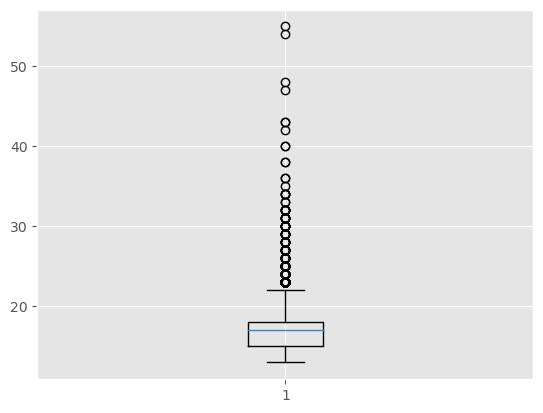

In [352]:
#age: Edades. Entendiendo que el estudio contempla alumnos del secundario y universidad.
df['age'].value_counts()

# Create a box plot
boxplot = plt.boxplot(df['age'])
print(boxplot)
outliers = [flier.get_ydata() for flier in boxplot['fliers']]
print(outliers)

In [353]:
#max.degree.parents: El grado maximo de estudio de los padres.

print(df['max.degree.parents'].value_counts())

df.groupby('max.degree.parents')['retention'].value_counts(normalize=True) * 100
#Ratio similar. Salvo en los que no tienen padres con degree, donde duplica el porcentaje.

Undergraduate degree    52494
No information          46100
Master degree           28802
No degree               11298
PhD                      4632
Name: max.degree.parents, dtype: int64


max.degree.parents    retention
Master degree         1            94.118464
                      0             5.881536
No degree             1            89.856612
                      0            10.143388
No information        1            89.110629
                      0            10.889371
PhD                   1            94.278929
                      0             5.721071
Undergraduate degree  1            93.305902
                      0             6.694098
Name: retention, dtype: float64

In [354]:
#father.education.complete: Educación completa del padre.
#mother.education.complete: Educación completa de la madre.

print(df['father.education.complete'].value_counts())
df['mother.education.complete'].value_counts()


Received undergraduate degree                 49888
No information                                49351
Received master degree                        22860
Graduated from high school                     5710
Attended university, but did not graduate      5506
Graduated from elementary or middle school     3741
Received PhD                                   3560
Received technical or commercial degree        2461
None educational degree                         249
Name: father.education.complete, dtype: int64


Received undergraduate degree                 53453
No information                                50458
Received master degree                        12892
Graduated from high school                     7727
Received technical or commercial degree        6834
Attended university, but did not graduate      6208
Graduated from elementary or middle school     3842
Received PhD                                   1782
None educational degree                         130
Name: mother.education.complete, dtype: int64

In [355]:
#father.education.summary: Educación resumida.
#mother.education.summary: Educación resumida.

print(df['father.education.summary'].value_counts())
df['mother.education.summary'].value_counts()


Undergraduate degree    49888
No information          49351
Master degree           22860
No degree               17667
PhD                      3560
Name: father.education.summary, dtype: int64


Undergraduate degree    53453
No information          50458
No degree               24741
Master degree           12892
PhD                      1782
Name: mother.education.summary, dtype: int64

In [356]:
#parents.exatec: Es ex Tecnologico de Monterrey.
#father.exatec: Es ex Tecnologico de Monterrey.
#mother.exatec: Es ex Tecnologico de Monterrey.

print(df['parents.exatec'].value_counts())
print(df['father.exatec'].value_counts())
df['mother.exatec'].value_counts()

No                94020
No information    24904
Yes               24402
Name: parents.exatec, dtype: int64
No                97845
No information    26612
Yes               18869
Name: father.exatec, dtype: int64


No                104787
No information     25988
Yes                12551
Name: mother.exatec, dtype: int64

In [357]:
#tec.no.tec: Viene de una escuela perteneciente al Tecnologico de Monterrey.

df['tec.no.tec'].value_counts()


NO TEC    102481
TEC        40845
Name: tec.no.tec, dtype: int64

In [358]:
#foreign: Si es de Monterrey, Mexico (local) o extranjero.

df['foreign'].value_counts()

Local             116933
Yes: National      22847
Yes: Foreigner      3546
Name: foreign, dtype: int64

In [359]:
#zone.type: Tipo de zona de donde viene el estudiante.

df['zone.type'].value_counts()

No information    101920
Urban              37915
Rural               2287
Semiurban           1204
Name: zone.type, dtype: int64

In [360]:
#first.generation: Primera generación en su familia que estudia una carrera profesional.

df['first.generation'].value_counts()

Does not apply    65809
No information    37372
No                34752
Yes                5393
Name: first.generation, dtype: int64

In [361]:
#school: Acronyms of the school to which the student's academic program belongs.

df['school'].value_counts()

High school                      65809
EIC                              35137
EN                               22570
EHE-EAAD                         10317
ECSG                              5384
EMCS                              3362
EAAD-Engineering and Sciences      747
Name: school, dtype: int64

In [362]:
#program: A que programa pertenece.
df['program'].value_counts()

PBB     38506
PTM     25147
NEG      7779
IIT      5822
IIS      5039
        ...  
LBC        29
LMI        27
IIN        25
LPL        16
LCMD        1
Name: program, Length: 76, dtype: int64

In [363]:
#region: Codigo de region en el campus.
df['region'].value_counts()

RCM    36678
RM     35432
RCS    33810
RO     27198
DR     10208
Name: region, dtype: int64

{'whiskers': [<matplotlib.lines.Line2D object at 0x7fcde8263460>, <matplotlib.lines.Line2D object at 0x7fcde82634f0>], 'caps': [<matplotlib.lines.Line2D object at 0x7fcde8263760>, <matplotlib.lines.Line2D object at 0x7fce089953d0>], 'boxes': [<matplotlib.lines.Line2D object at 0x7fcde82632b0>], 'medians': [<matplotlib.lines.Line2D object at 0x7fce08995340>], 'fliers': [<matplotlib.lines.Line2D object at 0x7fce08995550>], 'means': []}
[array([68.  , 69.19, 67.89, 68.11, 68.6 , 68.3 , 69.  , 62.33, 70.  ,
       70.  , 70.  , 70.  , 69.96, 69.02, 70.02, 66.67, 68.88, 70.07,
       70.  , 68.44, 68.  , 70.  , 70.  , 70.  , 65.  , 67.  , 69.  ,
       66.  , 70.  , 68.  , 69.  , 70.  , 70.  , 69.  , 70.  , 70.  ,
       70.  , 68.86, 70.  , 69.  , 67.  , 66.  , 67.  , 70.  , 68.44,
       68.84, 69.12, 69.69, 70.  , 70.  , 69.96, 66.14, 67.73, 69.86,
       70.09, 69.  , 69.  , 70.31, 70.  , 70.05, 70.  , 68.  , 69.62,
       70.32, 70.  , 70.12, 68.  , 70.  , 70.  , 70.  , 70.  , 70.  ,
 

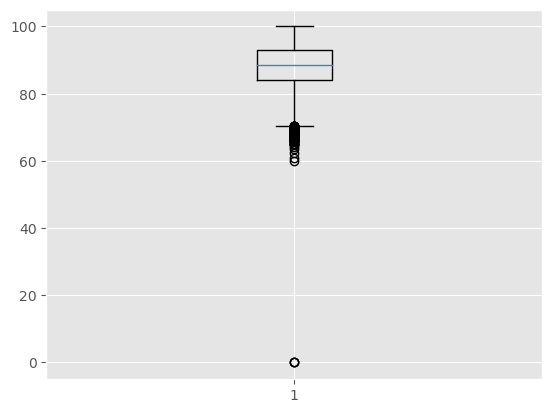

In [364]:
#PNA: Previous level score (average).
df['PNA'].value_counts()

# Create a box plot
boxplot = plt.boxplot(df['PNA'])
print(boxplot)
outliers = [flier.get_ydata() for flier in boxplot['fliers']]
print(outliers)

In [365]:
#admission.test: Score en la prueba de admisión.
df['admission.test'].value_counts()

df['admission.test'] = df['admission.test'].replace('Does not apply ', -1) #Para que la columna entera quede númerica
df['admission.test'] = df['admission.test'].astype(float)


In [371]:
df['admission.test'].value_counts()


-1.0       24624
 1320.0     1147
 1370.0     1087
 1220.0     1081
 1350.0     1069
           ...  
 769.0         1
 846.0         1
 774.0         1
 701.0         1
 19.0          1
Name: admission.test, Length: 907, dtype: int64

In [366]:
#online.test: online la prueba de admisión.
df['online.test'].value_counts()

0    142204
1      1122
Name: online.test, dtype: int64

In [367]:
#english.evaluation: 
df['english.evaluation'].value_counts()

6    49296
0    48515
7    14165
5     8248
4     7872
1     5950
3     5689
2     3591
Name: english.evaluation, dtype: int64

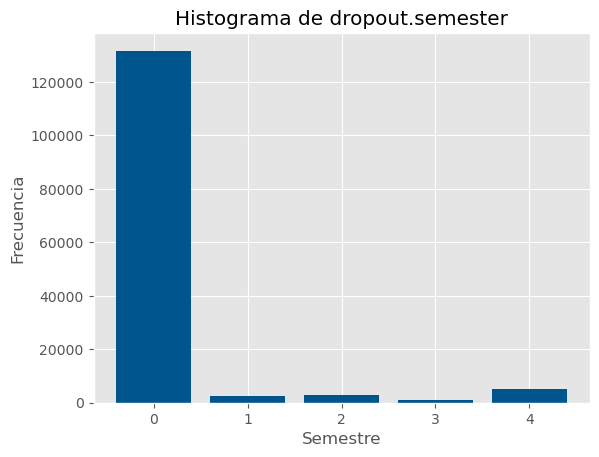

In [368]:
df['dropout.semester'].value_counts()

# Obtener los valores y frecuencias
counts = df['dropout.semester'].value_counts()

# Crear el histograma
plt.bar(counts.index, counts.values, color='#00558c')

# Etiquetas y título
plt.xlabel('Semestre')
plt.ylabel('Frecuencia')
plt.title('Histograma de dropout.semester')

# Mostrar el histograma
plt.show()

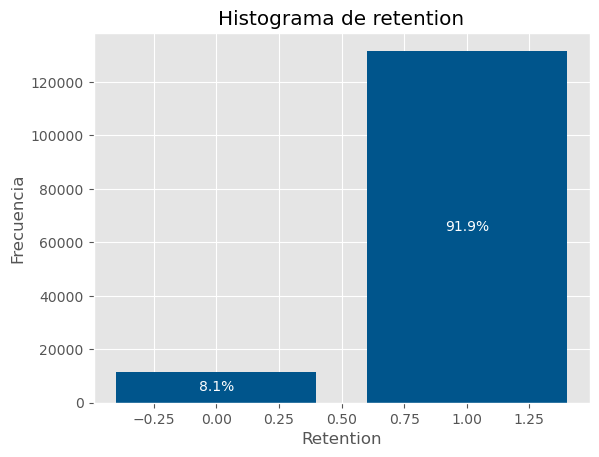

In [422]:
import matplotlib.pyplot as plt

# Obtener los valores y frecuencias
counts = df['retention'].value_counts()

# Crear el histograma
bars = plt.bar(counts.index, counts.values, color='#00558c')

# Etiquetas y título
plt.xlabel('Retention')
plt.ylabel('Frecuencia')
plt.title('Histograma de retention')

# Agregar el porcentaje en el medio de cada barra en letra blanca
for bar in bars:
    height = bar.get_height()
    percentage = f'{(height / sum(counts.values)):.1%}'
    plt.text(bar.get_x() + bar.get_width() / 2, height / 2, percentage, ha='center', va='center', color='white')

# Mostrar el histograma
plt.show()


## Missings

La base, como se pudo ver al principio al ver su información general, no contiene valores nulos. Sin embargo, si contempla la existencia de valores como "No Information" o "Does not apply".

In [322]:
total = df.isnull().sum()
total1 = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total1, percent], axis = 1, keys = ['Total', 'Percent'])
missing_data

,Total,Percent
failed.subject.first.period,99534,0.694459
dropped.subject.first.period,99534,0.694459
average.first.period,99534,0.694459
admission.rubric,33489,0.233656
admission.test,2177,0.015189
art.culture,0,0.000000
socioeconomic.level,0,0.000000
FTE,0,0.000000
scholarship.perc,0,0.000000
scholarship.type,0,0.000000


## Outliers

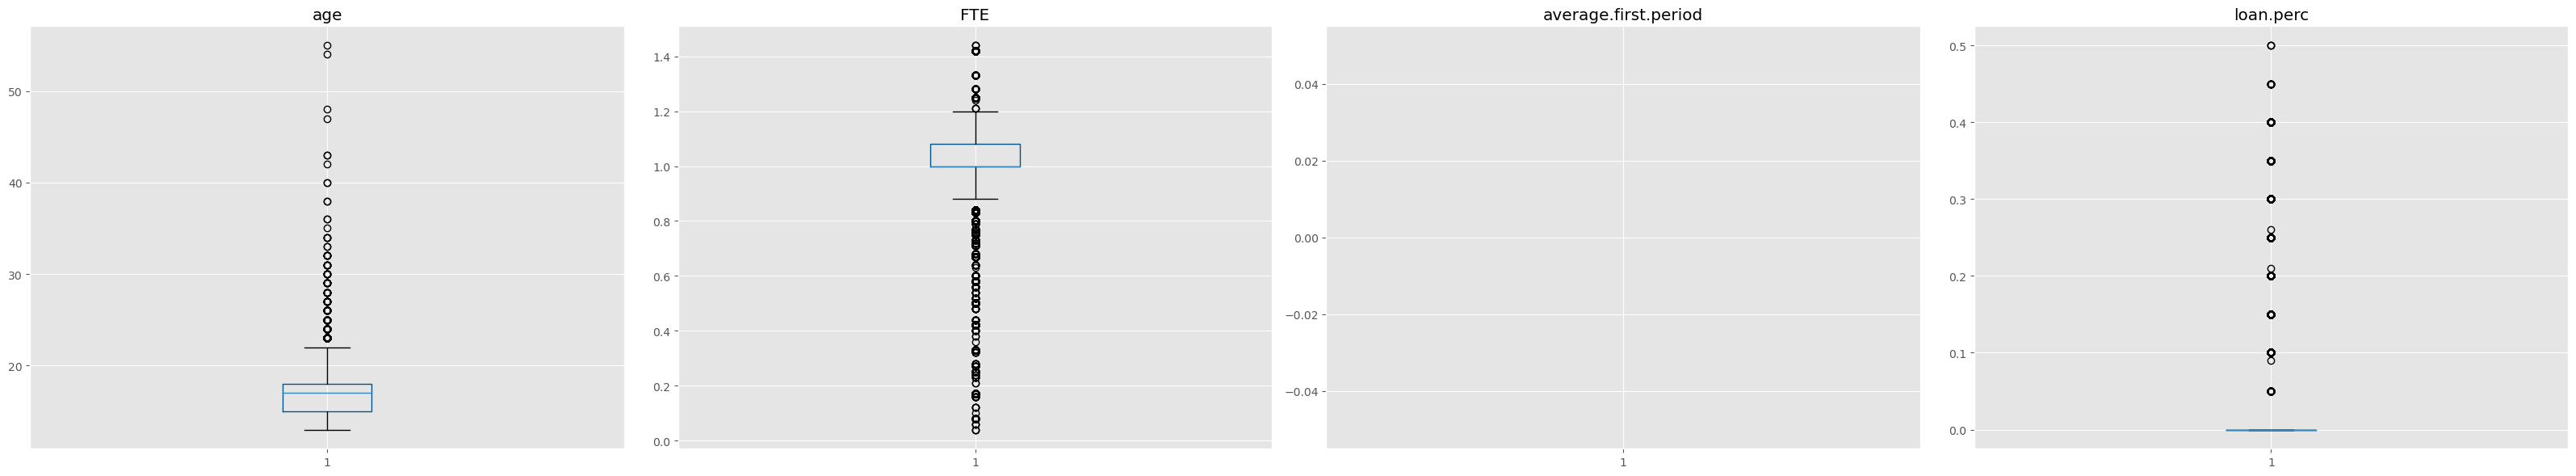

In [323]:

columns_of_interest = ['age', 'FTE', 'average.first.period', 'loan.perc']

# Ajustar el tamaño de la figura
fig_width = 8 * len(columns_of_interest)
fig_height = 6
fig, axs = plt.subplots(1, len(columns_of_interest), figsize=(fig_width, fig_height))

# Iterar sobre las columnas de interés y crear los boxplots correspondientes
for i, column in enumerate(columns_of_interest):
    axs[i].boxplot(df[column], boxprops={'color': '#00558c'})
    axs[i].set_title(column)

# Ajustar el espacio entre subplots
plt.tight_layout()

# Mostrar los boxplots
plt.show()



## Tendencias de la variable a predecir

In [324]:
df.corr()['retention'].count()

16

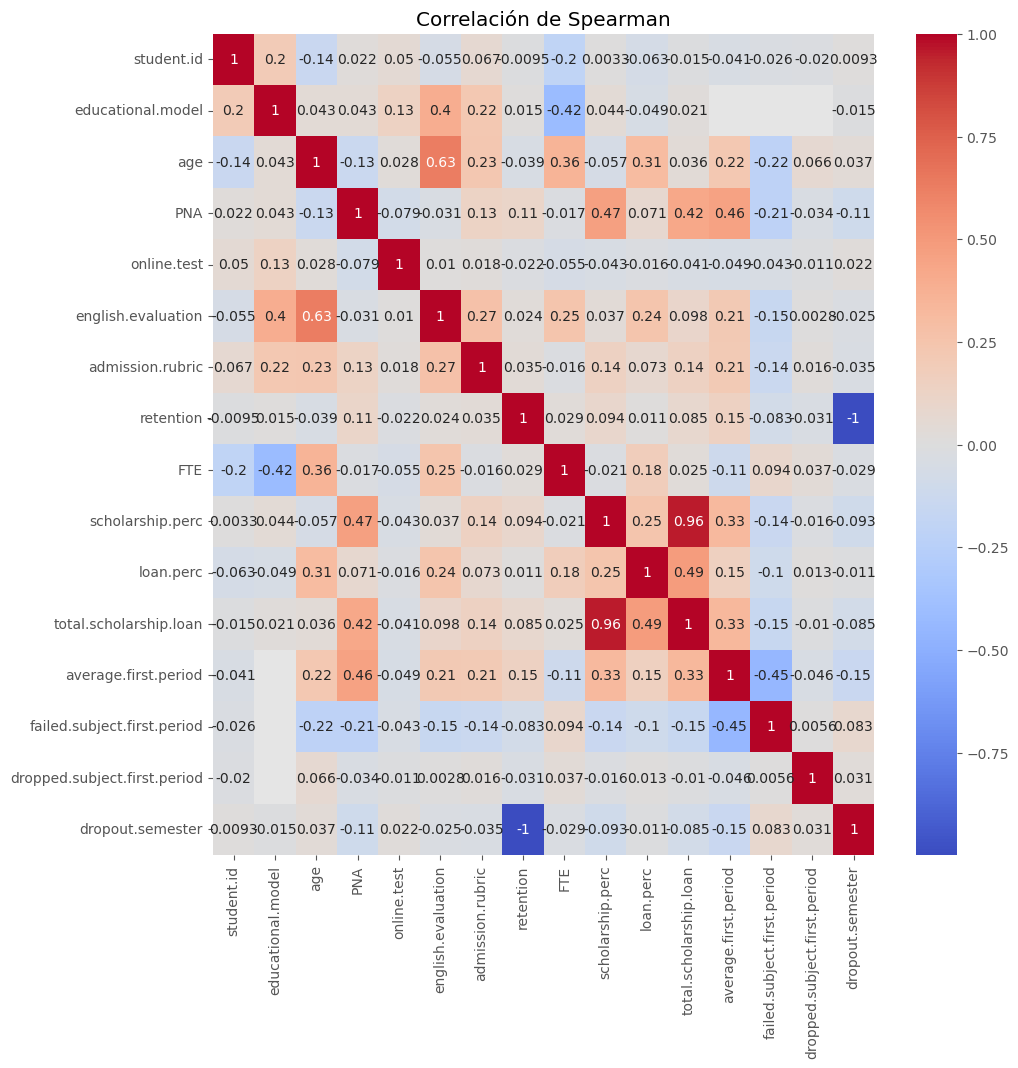

In [325]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de correlación de Spearman
correlation_matrix = df.corr(method = 'spearman')

# Ajustar el tamaño de la figura en función de la cantidad de variables
fig, ax = plt.subplots(figsize=(len(correlation_matrix.columns) / 1.5, len(correlation_matrix.columns) / 1.5))

# Crear el gráfico de correlación
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# Título del gráfico
plt.title('Correlación de Spearman')

# Ajustar los límites de los ejes
plt.ylim(len(correlation_matrix.columns), 0)
plt.xlim(0, len(correlation_matrix.columns))

# Mostrar el gráfico
plt.show()


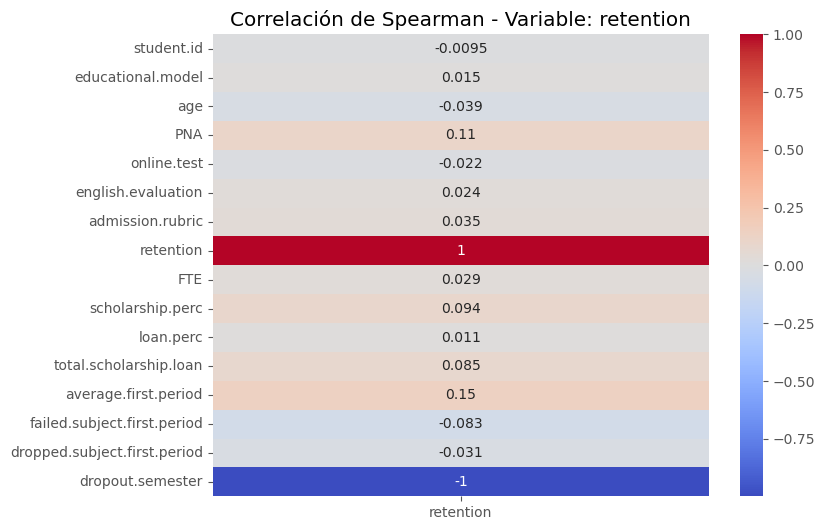

In [326]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de correlación de Spearman solo para 'retention'
correlation_matrix = df.corr(method='spearman')['retention']

# Ajustar el tamaño de la figura en función de la cantidad de variables
fig, ax = plt.subplots(figsize=(8,6))

# Crear el gráfico de correlación
sns.heatmap(correlation_matrix.to_frame(), annot=True, cmap='coolwarm')

# Título del gráfico
plt.title('Correlación de Spearman - Variable: retention')

# Ajustar los límites de los ejes
plt.ylim(len(correlation_matrix), 0)
plt.xlim(0, 1)

# Mostrar el gráfico
plt.show()



In [440]:
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Obtener las columnas categóricas
categorical_cols = df.select_dtypes(include=['object']).columns

# Calcular la correlación de Cramer's V entre todas las columnas categóricas
for col1 in categorical_cols:
        if col1 != 'retention':
            correlation = cramers_v(df[col1], df['retention'])
            print(f"Cramer's V correlation between {col1} and retention: {correlation}")


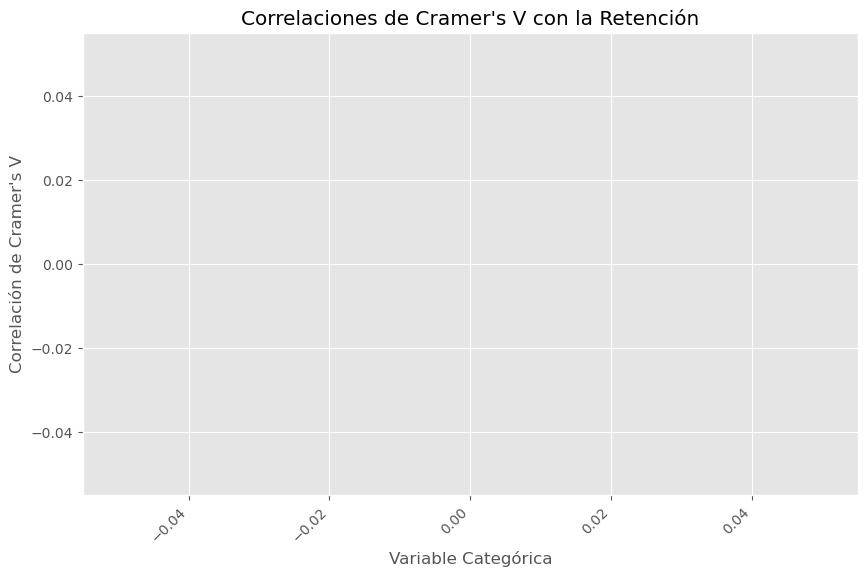

In [439]:
import matplotlib.pyplot as plt

# Obtener las columnas categóricas
categorical_cols = df.select_dtypes(include=['object']).columns

# Lista para almacenar las correlaciones
correlations = []

# Calcular la correlación de Cramer's V entre todas las columnas categóricas
for col1 in categorical_cols:
    if col1 != 'retention':
        correlation = cramers_v(df[col1], df['retention'])
        correlations.append((col1, correlation))

# Ordenar las correlaciones de forma descendente
correlations.sort(key=lambda x: x[1], reverse=True)

# Extraer los nombres de las variables y las correlaciones
variable_names = [x[0] for x in correlations]
correlation_values = [x[1] for x in correlations]

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(variable_names, correlation_values, color='#00558c')

# Etiquetas y título del gráfico
plt.xlabel('Variable Categórica')
plt.ylabel("Correlación de Cramer's V")
plt.title("Correlaciones de Cramer's V con la Retención")

# Rotar las etiquetas del eje x para mayor legibilidad
plt.xticks(rotation=45, ha='right')

# Mostrar el gráfico
plt.show()




In [431]:
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Obtener las columnas categóricas
categorical_cols = df.select_dtypes(include=['object']).columns

# Calcular la correlación de Cramer's V entre todas las columnas categóricas
for col1 in categorical_cols:
        if col1 != 'retention':
            correlation = cramers_v(df[col1], df['retention'])
            print(f"Cramer's V correlation between {col1} and retention: {correlation}")


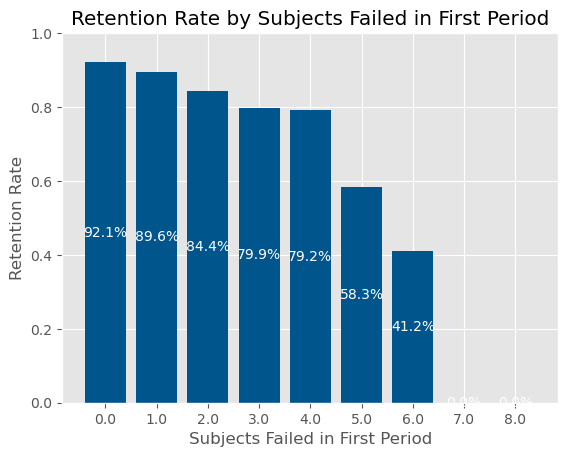

In [420]:
import matplotlib.pyplot as plt

# Agrupar los datos por generación y calcular la retención media
generation_retention = df.groupby('failed.subject.first.period')['retention'].mean()

# Obtener los nombres de las generaciones y sus posiciones en el eje x
generation_names = generation_retention.index
x_pos = range(len(generation_names))

# Crear el gráfico de barras
bars = plt.bar(x_pos, generation_retention, color='#00558c')

# Etiquetas de los ejes y título del gráfico
plt.xlabel('Subjects Failed in First Period')
plt.ylabel('Retention Rate')
plt.title('Retention Rate by Subjects Failed in First Period')

# Establecer los límites del eje y en el rango de 0 a 1
plt.ylim(0, 1)


# Personalizar el eje x con los nombres de las generaciones
plt.xticks(x_pos, generation_names)

# Agregar los valores de retención como porcentaje dentro de las barras en letra blanca
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height / 2, f'{height:.1%}', ha='center', va='center', color='white')

# Mostrar el gráfico
plt.show()






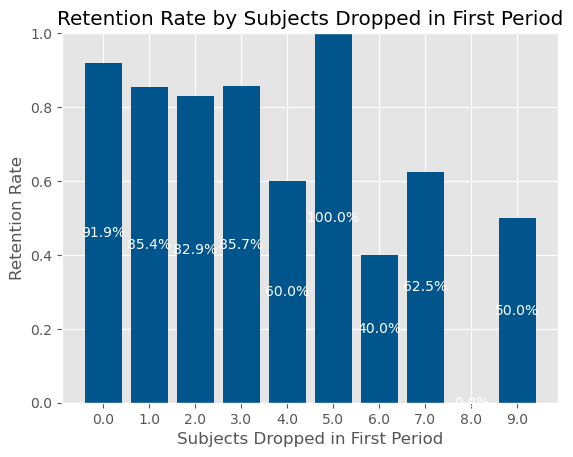

In [443]:
import matplotlib.pyplot as plt

# Agrupar los datos por generación y calcular la retención media
generation_retention = df.groupby('dropped.subject.first.period')['retention'].mean()

# Obtener los nombres de las generaciones y sus posiciones en el eje x
generation_names = generation_retention.index
x_pos = range(len(generation_names))

# Crear el gráfico de barras
bars = plt.bar(x_pos, generation_retention, color='#00558c')

# Etiquetas de los ejes y título del gráfico
plt.xlabel('Subjects Dropped in First Period')
plt.ylabel('Retention Rate')
plt.title('Retention Rate by Subjects Dropped in First Period')

# Establecer los límites del eje y en el rango de 0 a 1
plt.ylim(0, 1)


# Personalizar el eje x con los nombres de las generaciones
plt.xticks(x_pos, generation_names)

# Agregar los valores de retención como porcentaje dentro de las barras en letra blanca
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height / 2, f'{height:.1%}', ha='center', va='center', color='white')

# Mostrar el gráfico
plt.show()


In [444]:
df['dropped.subject.first.period'].value_counts()

0.0    143041
1.0       192
2.0        41
3.0        21
4.0        10
7.0         8
5.0         5
6.0         5
9.0         2
8.0         1
Name: dropped.subject.first.period, dtype: int64

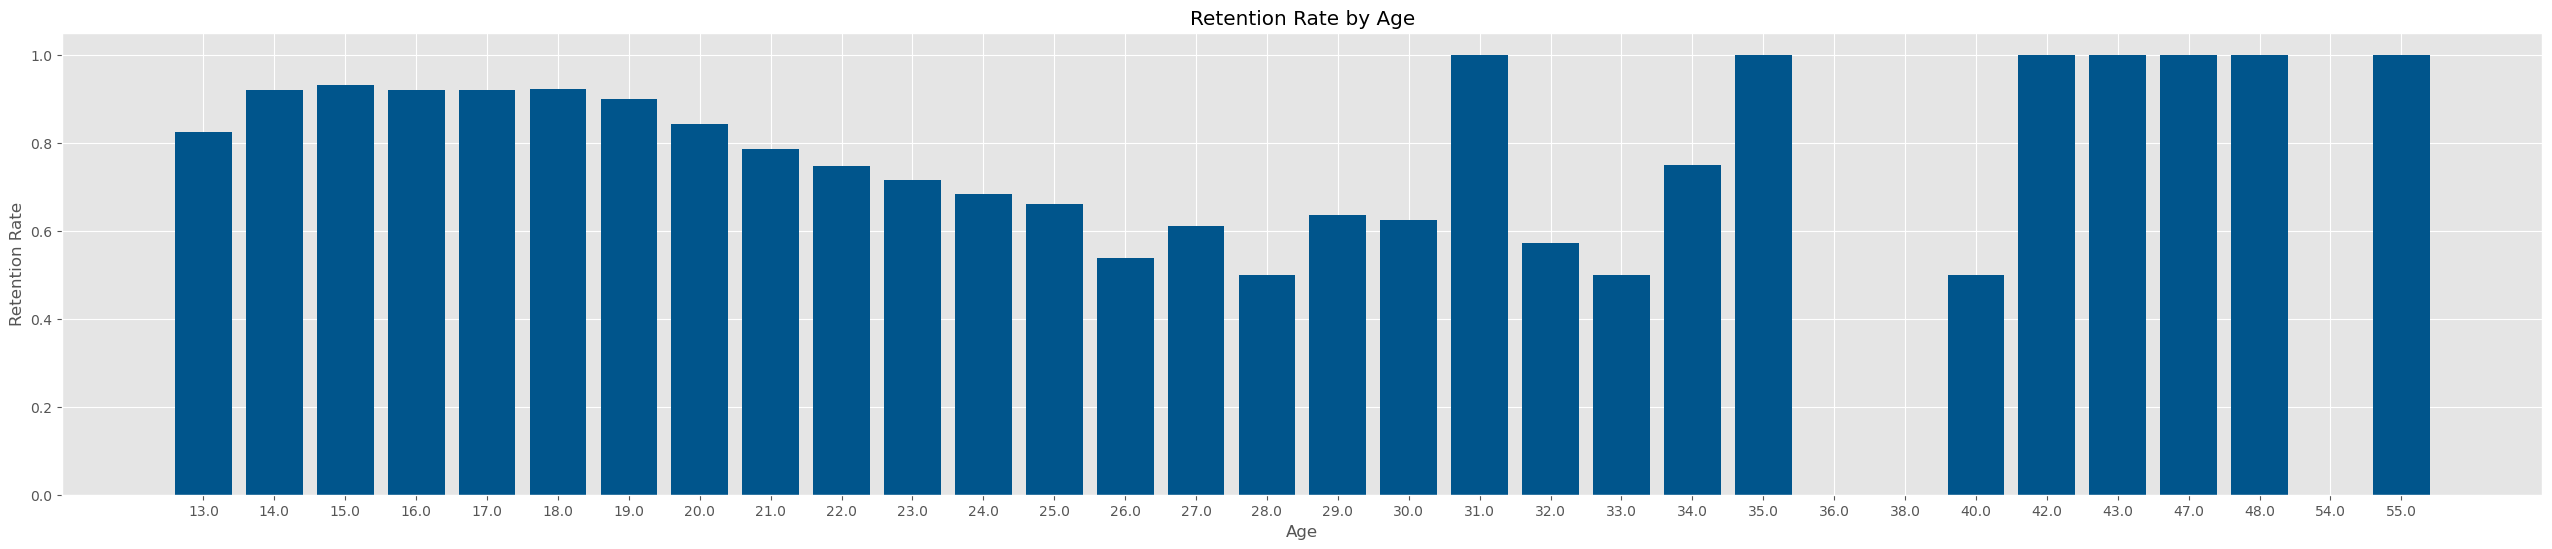

In [427]:
import matplotlib.pyplot as plt
import numpy as np

# Calcular la proporción de estudiantes retenidos por grupo de edad
age_retention = df.groupby('age')['retention'].mean()

# Obtener los valores únicos de edad y sus posiciones en el eje x
unique_age = np.sort(df['age'].unique())
x_pos = np.arange(len(unique_age))

# Ajustar el tamaño de la figura
fig, ax = plt.subplots(figsize=(len(unique_age) , 6))

# Crear el gráfico de barras
plt.bar(x_pos, age_retention, color='#00558c')

# Etiquetas de los ejes y título del gráfico
plt.xlabel('Age')
plt.ylabel('Retention Rate')
plt.title('Retention Rate by Age')

# Personalizar el eje x con los valores únicos de edad
plt.xticks(x_pos, unique_age)

# Mostrar el gráfico
plt.show()




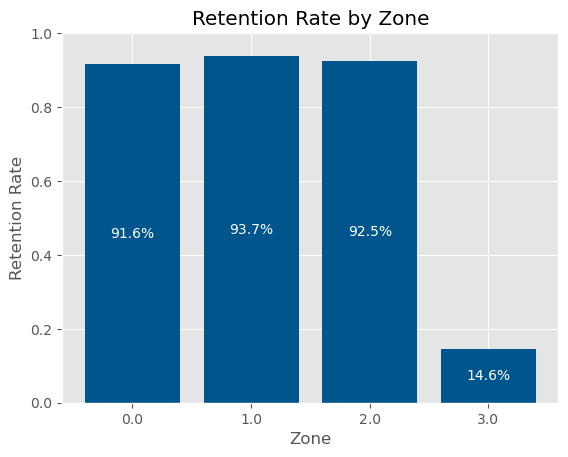

In [441]:
import matplotlib.pyplot as plt

# Agrupar los datos por generación y calcular la retención media
generation_retention = df.groupby('student.society')['retention'].mean()

# Obtener los nombres de las generaciones y sus posiciones en el eje x
generation_names = generation_retention.index
x_pos = range(len(generation_names))

# Crear el gráfico de barras
bars = plt.bar(x_pos, generation_retention, color='#00558c')

# Etiquetas de los ejes y título del gráfico
plt.xlabel('Zone')
plt.ylabel('Retention Rate')
plt.title('Retention Rate by Zone')

# Establecer los límites del eje y en el rango de 0 a 1
plt.ylim(0, 1)

# Personalizar el eje x con los nombres de las generaciones
plt.xticks(x_pos, generation_names)

# Agregar los valores de retención como porcentaje dentro de las barras en letra blanca
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height / 2, f'{height:.1%}', ha='center', va='center', color='white')

# Mostrar el gráfico
plt.show()


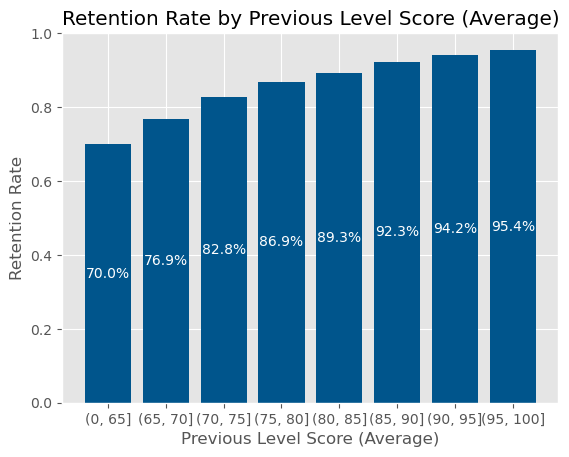

In [331]:
import matplotlib.pyplot as plt

# Agrupar los datos por el rango del porcentaje de becas y préstamos totales
scholarship_loan_ranges = pd.cut(df['PNA'], bins=[0,65, 70,75, 80,85, 90,95,  100])
retention_rate = df.groupby(scholarship_loan_ranges)['retention'].mean()

# Obtener los nombres de los rangos y sus posiciones en el eje x
range_names = retention_rate.index.astype(str)
x_pos = range(len(range_names))

# Crear el gráfico de barras
bars = plt.bar(x_pos, retention_rate, color='#00558c')

# Etiquetas de los ejes y título del gráfico
plt.xlabel('Previous Level Score (Average)')
plt.ylabel('Retention Rate')
plt.title('Retention Rate by Previous Level Score (Average)')

# Personalizar el eje x con los nombres de los rangos
plt.xticks(x_pos, range_names)

# Ajustar los límites del eje y en el rango de 0 a 1
plt.ylim(0, 1)

# Agregar los valores de retención como porcentaje dentro de las barras en letra blanca
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height / 2, f'{height:.1%}', ha='center', va='center', color='white')

# Mostrar el gráfico
plt.show()



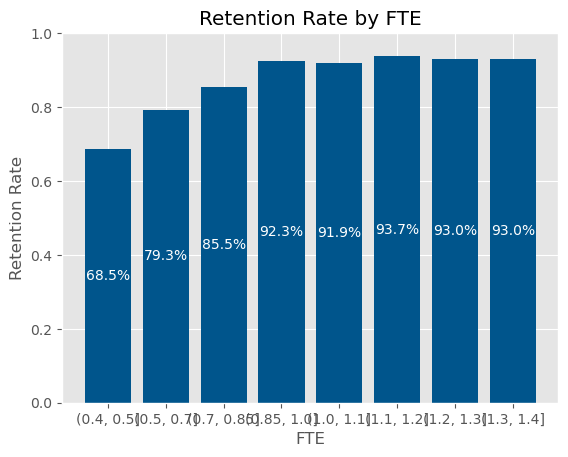

In [446]:
import matplotlib.pyplot as plt

# Agrupar los datos por el rango del porcentaje de becas y préstamos totales
scholarship_loan_ranges = pd.cut(df['FTE'], bins=[0.4,0.5, 0.70, 0.85, 1,1.1, 1.2,1.3,  1.4])
retention_rate = df.groupby(scholarship_loan_ranges)['retention'].mean()

# Obtener los nombres de los rangos y sus posiciones en el eje x
range_names = retention_rate.index.astype(str)
x_pos = range(len(range_names))

# Crear el gráfico de barras
bars = plt.bar(x_pos, retention_rate, color='#00558c')

# Etiquetas de los ejes y título del gráfico
plt.xlabel('FTE')
plt.ylabel('Retention Rate')
plt.title('Retention Rate by FTE')

# Personalizar el eje x con los nombres de los rangos
plt.xticks(x_pos, range_names)

# Ajustar los límites del eje y en el rango de 0 a 1
plt.ylim(0, 1)

# Agregar los valores de retención como porcentaje dentro de las barras en letra blanca
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height / 2, f'{height:.1%}', ha='center', va='center', color='white')

# Mostrar el gráfico
plt.show()

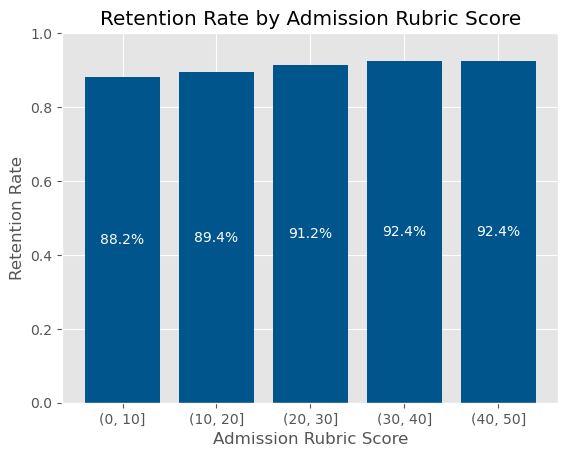

In [332]:
import matplotlib.pyplot as plt

# Agrupar los datos por el rango del porcentaje de becas y préstamos totales
scholarship_loan_ranges = pd.cut(df['admission.rubric'], bins=[0, 10, 20, 30,  40,50])
retention_rate = df.groupby(scholarship_loan_ranges)['retention'].mean()

# Obtener los nombres de los rangos y sus posiciones en el eje x
range_names = retention_rate.index.astype(str)
x_pos = range(len(range_names))

# Crear el gráfico de barras
bars = plt.bar(x_pos, retention_rate, color='#00558c')

# Etiquetas de los ejes y título del gráfico
plt.xlabel('Admission Rubric Score')
plt.ylabel('Retention Rate')
plt.title('Retention Rate by Admission Rubric Score')

# Personalizar el eje x con los nombres de los rangos
plt.xticks(x_pos, range_names)

# Ajustar los límites del eje y en el rango de 0 a 1
plt.ylim(0, 1)

# Agregar los valores de retención como porcentaje dentro de las barras en letra blanca
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height / 2, f'{height:.1%}', ha='center', va='center', color='white')

# Mostrar el gráfico
plt.show()

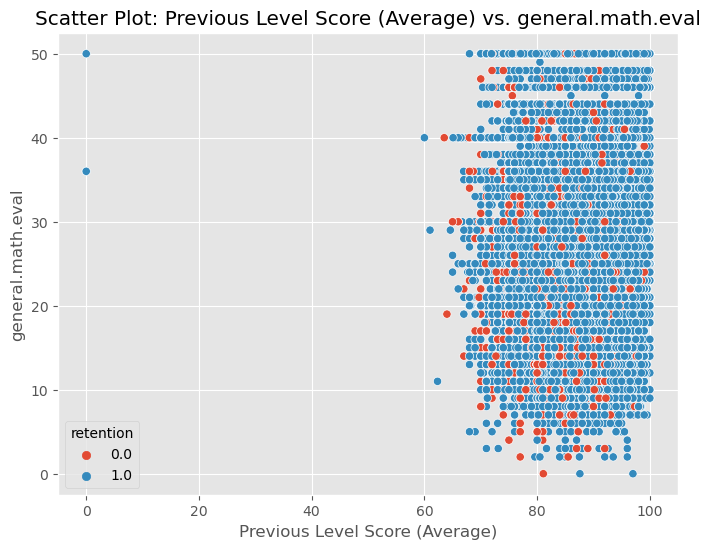

In [458]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear el scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PNA', y='admission.rubric', hue='retention', data=df)

# Añadir etiquetas y título
plt.xlabel('Previous Level Score (Average)')
plt.ylabel('general.math.eval')
plt.title('Scatter Plot: Previous Level Score (Average) vs. general.math.eval')

# Mostrar el gráfico
plt.show()


## Conversión de columnas categoricas a numericas

In [373]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer

categorical_columns = [c for c in df.columns if df[c].dtype == 'object']
numerical_columns = [c for c in df.columns if c not in categorical_columns]

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('encoder', OrdinalEncoder())
])

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

df2 = df

df2[categorical_columns] = categorical_pipeline.fit_transform(df2[categorical_columns])
df2[numerical_columns] = numerical_pipeline.fit_transform(df2[numerical_columns])

df2.head()

/Users/manu/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


,student.id,generation,educational.model,level,gender,age,max.degree.parents,father.education.complete,father.education.summary,mother.education.complete,mother.education.summary,parents.exatec,father.exatec,mother.exatec,tec.no.tec,foreign,zone.type,first.generation,school,program,region,PNA,admission.test,online.test,english.evaluation,admission.rubric,general.math.eval,retention,FTE,scholarship.perc,scholarship.type,loan.perc,total.scholarship.loan,school.cost,id.school.origin,socioeconomic.level,social.lag,average.first.period,failed.subject.first.period,dropped.subject.first.period,dropout.semester,physical.education,cultural.diffusion,student.society,total.life.activities,athletic.sports,art.culture,student.society.leadership,life.work.mentoring,wellness.activities
1,1.0,1.0,0.0,0.0,1.0,15.0,2.0,3.0,2.0,3.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,6.0,70.0,0.0,75.00,793.0,0.0,0.0,40.0,421.0,0.0,1.00,0.00,8.0,0.00,0.000000,0.0,2026.0,7.0,3.0,93.0,0.0,0.0,1.0,3.0,3.0,3.0,6.0,2.0,2.0,2.0,2.0,2.0
2,2.0,0.0,0.0,1.0,1.0,19.0,2.0,3.0,2.0,3.0,2.0,1.0,1.0,1.0,1.0,2.0,0.0,2.0,5.0,45.0,4.0,87.00,-1.0,0.0,6.0,40.0,306.0,1.0,1.08,0.00,8.0,0.00,0.000000,0.0,5059.0,7.0,3.0,93.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2.0,2.0,2.0,2.0,2.0
3,3.0,4.0,0.0,1.0,1.0,23.0,4.0,8.0,4.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,3.0,19.0,3.0,83.76,-1.0,0.0,6.0,40.0,368.0,0.0,1.08,0.35,10.0,0.25,0.599998,0.0,5059.0,7.0,3.0,93.0,0.0,0.0,4.0,2.0,2.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0
4,4.0,0.0,0.0,1.0,1.0,19.0,2.0,3.0,2.0,3.0,2.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,5.0,45.0,4.0,71.00,1220.0,0.0,6.0,24.0,37.0,1.0,1.08,0.00,8.0,0.00,0.000000,4.0,5361.0,7.0,3.0,93.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2.0,2.0,2.0,2.0,2.0
5,5.0,0.0,0.0,1.0,1.0,17.0,2.0,3.0,2.0,3.0,2.0,0.0,0.0,0.0,1.0,2.0,0.0,2.0,3.0,21.0,3.0,96.86,1529.0,0.0,6.0,40.0,418.0,1.0,1.08,0.90,10.0,0.00,0.900003,0.0,5059.0,7.0,3.0,93.0,0.0,0.0,0.0,1.0,1.0,1.0,6.0,2.0,2.0,2.0,2.0,2.0


In [374]:
df2.corr()['retention']

student.id                     -0.009353
generation                      0.022910
educational.model               0.015094
level                          -0.026557
gender                         -0.012602
age                            -0.049250
max.degree.parents              0.009224
father.education.complete       0.062207
father.education.summary        0.015705
mother.education.complete       0.067669
mother.education.summary        0.035550
parents.exatec                  0.014880
father.exatec                   0.006850
mother.exatec                  -0.007717
tec.no.tec                      0.014762
foreign                        -0.023867
zone.type                       0.017527
first.generation               -0.034011
school                          0.024210
program                         0.017224
region                          0.022421
PNA                             0.108196
admission.test                  0.023835
online.test                    -0.021994
english.evaluati

## Split de la Base

In [397]:
from sklearn.model_selection import train_test_split

X = df2.drop(['dropout.semester','retention'], axis=1)
y = df2['retention']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify = y, random_state=1411)
val = pd.concat([X_val, y_val], axis=1)

train = pd.concat([X_train, y_train], axis=1)

In [445]:
val.groupby('max.degree.parents')['retention'].value_counts(normalize=True) * 100 #porcentajes similares

KeyError: 'Column not found: retention'

In [399]:
valpred = val['retention']
val = val.drop('retention', axis=1)


In [400]:
# Reset the index and rename the column to 'id'
valpred = valpred.reset_index().rename(columns={'index': 'id'})

valpred['Usage'] = 'Public'
# Print the updated DataFrame
print(valpred)


           id  retention   Usage
0        4287        1.0  Public
1      131864        1.0  Public
2      107197        1.0  Public
3       80915        1.0  Public
4      116087        0.0  Public
...       ...        ...     ...
28661  114622        1.0  Public
28662   59203        1.0  Public
28663   15669        1.0  Public
28664    5310        1.0  Public
28665  111151        1.0  Public

[28666 rows x 3 columns]


In [401]:
val.to_csv('val.csv')
valpred.to_csv('valpred.csv', index = False)
train.to_csv('train.csv')

In [402]:
valpred

,id,retention,Usage
0,4287,1.0,Public
1,131864,1.0,Public
2,107197,1.0,Public
3,80915,1.0,Public
4,116087,0.0,Public
...,...,...,...
28661,114622,1.0,Public
28662,59203,1.0,Public
28663,15669,1.0,Public
28664,5310,1.0,Public
